**Table of contents**<a id='toc0_'></a>    
- [0. Imports](#toc1_1_)    
  - [1. Data preprocessing](#toc1_2_)    
    - [1.1 Combining files](#toc1_2_1_)    
    - [1.2 Cleaning up column names](#toc1_2_2_)    
    - [1.3 One-hot encoding categorical variables](#toc1_2_3_)    
  - [2. EDA](#toc1_3_)    
    - [Data statistics](#toc1_3_1_)    
    - [2.2 Intro plots](#toc1_3_2_)    
  - [3. Basic Model: Logistic Regression](#toc1_4_)    
    - [3.1 Model Architecture](#toc1_4_1_)    
    - [3.2 Data Preparation for Training](#toc1_4_2_)    
    - [3.3 Model Training](#toc1_4_3_)    
    - [3.4 Model Evaluation](#toc1_4_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[0. Imports](#toc0_)

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

## <a id='toc1_2_'></a>[1. Data preprocessing](#toc0_)

### <a id='toc1_2_1_'></a>[1.1 Combining files](#toc0_)

In [7]:
## Combining the kaggle test & train datasets
df1 = pd.read_csv("data/kaggletest.csv")
df2 = pd.read_csv("data/kaggletrain.csv")
combined = pd.concat([df1, df2], ignore_index=True)
combined.to_csv("data/kaggle.csv", index=False)

## Check that it worked
len(df1) + len(df2) == len(combined)

True

### <a id='toc1_2_2_'></a>[1.2 Cleaning up column names](#toc0_)

In [8]:
# Renaming for easier interpretability
combined = combined.rename(columns={
    'cp': 'chest pain type',
    'trestbps': 'rest blood pressure',
    'chol': 'serum cholesterol',
    'fbs': 'fasting blood sugar',
    'restecg': 'rest ecg',
    'thalach': 'max heart rate',
    'exang': 'exercise induced angina',
    'thal': 'thalassemia',
    'ca': 'major vessels'
})

combined.head()


,age,sex,chest pain type,rest blood pressure,serum cholesterol,fasting blood sugar,rest ecg,max heart rate,exercise induced angina,oldpeak,slope,major vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### <a id='toc1_2_3_'></a>[1.3 One-hot encoding categorical variables](#toc0_)

In [9]:
# One hot encoding categorical variables with more than one category to not
# by mistake introduce unintended ordinality

encoder = OneHotEncoder(sparse_output=False)
onehotcols = ['chest pain type', 'rest ecg', 'thalassemia', 'major vessels', 'slope']
encoded = encoder.fit_transform(combined[onehotcols])

encoded_df = pd.DataFrame(
    encoded, 
    columns=encoder.get_feature_names_out()
)

df = combined.drop(columns=onehotcols)
df = pd.concat([df, encoded_df], axis=1)

## <a id='toc1_3_'></a>[2. EDA](#toc0_)

### <a id='toc1_3_1_'></a>[2.1 Data statistics](#toc0_)

In [10]:
df[cont_vars].describe()

NameError: name 'cont_vars' is not defined

### <a id='toc1_3_2_'></a>[2.2 Intro plots](#toc0_)

/var/folders/g7/03t5vzrs7zgbycw7q8mm4svw0000gn/T/ipykernel_6454/1332783081.py:15: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  g.fig.legend(


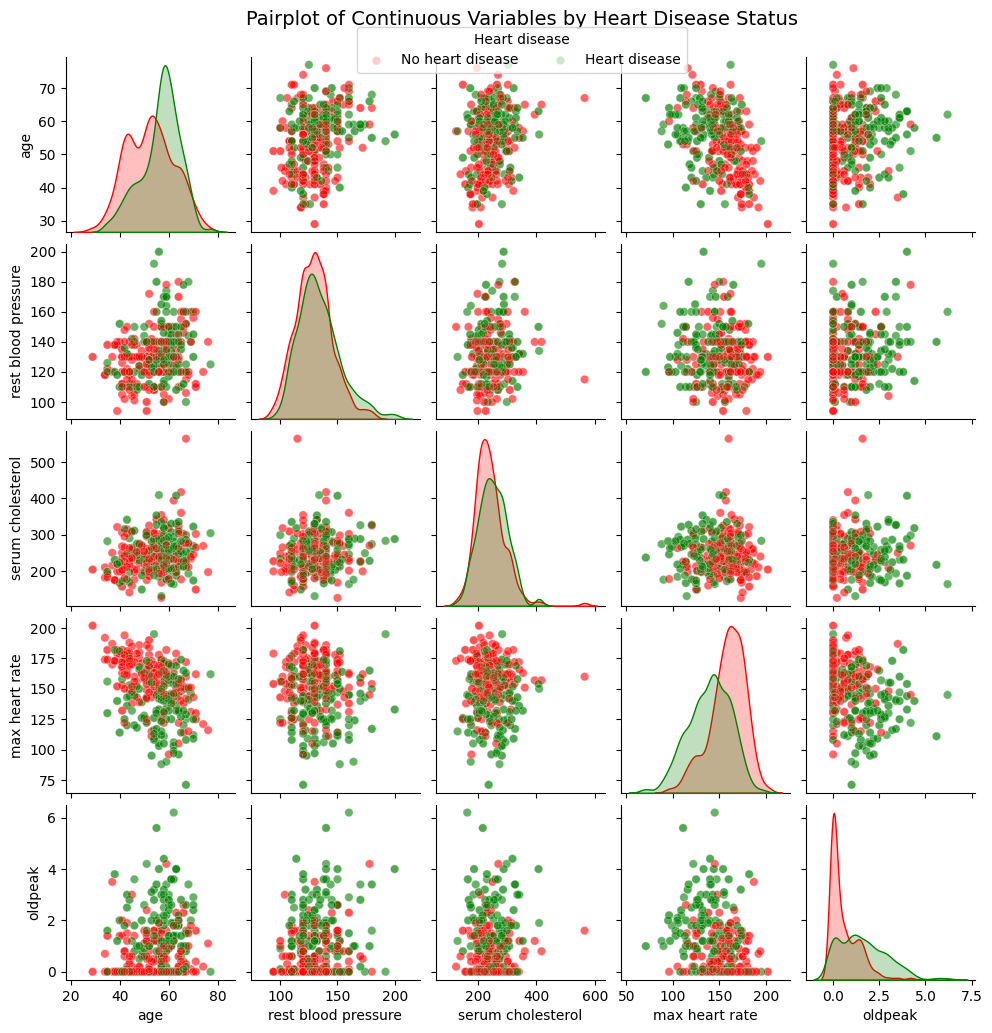

In [ ]:
## Plots for continuous variables
cont_vars = ['age', 'rest blood pressure', 'serum cholesterol', 'max heart rate', 'oldpeak'] 
palette_target = {0: 'green', 1: 'red'}

g = sns.pairplot(
    df[cont_vars + ['target']],
    hue='target',
    palette=palette_target,
    height=2.0,
    plot_kws={'alpha': 0.2}
)

# Remove default legend and replace with more detailed one 
g._legend.remove()
g.fig.legend(
    handles,
    labels=["No heart disease", "Heart disease"],
    title="Heart disease",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=2
)

g.fig.suptitle(
    "Pairplot of Continuous Variables by Heart Disease Status",
    y=1.03,
    fontsize=14
);

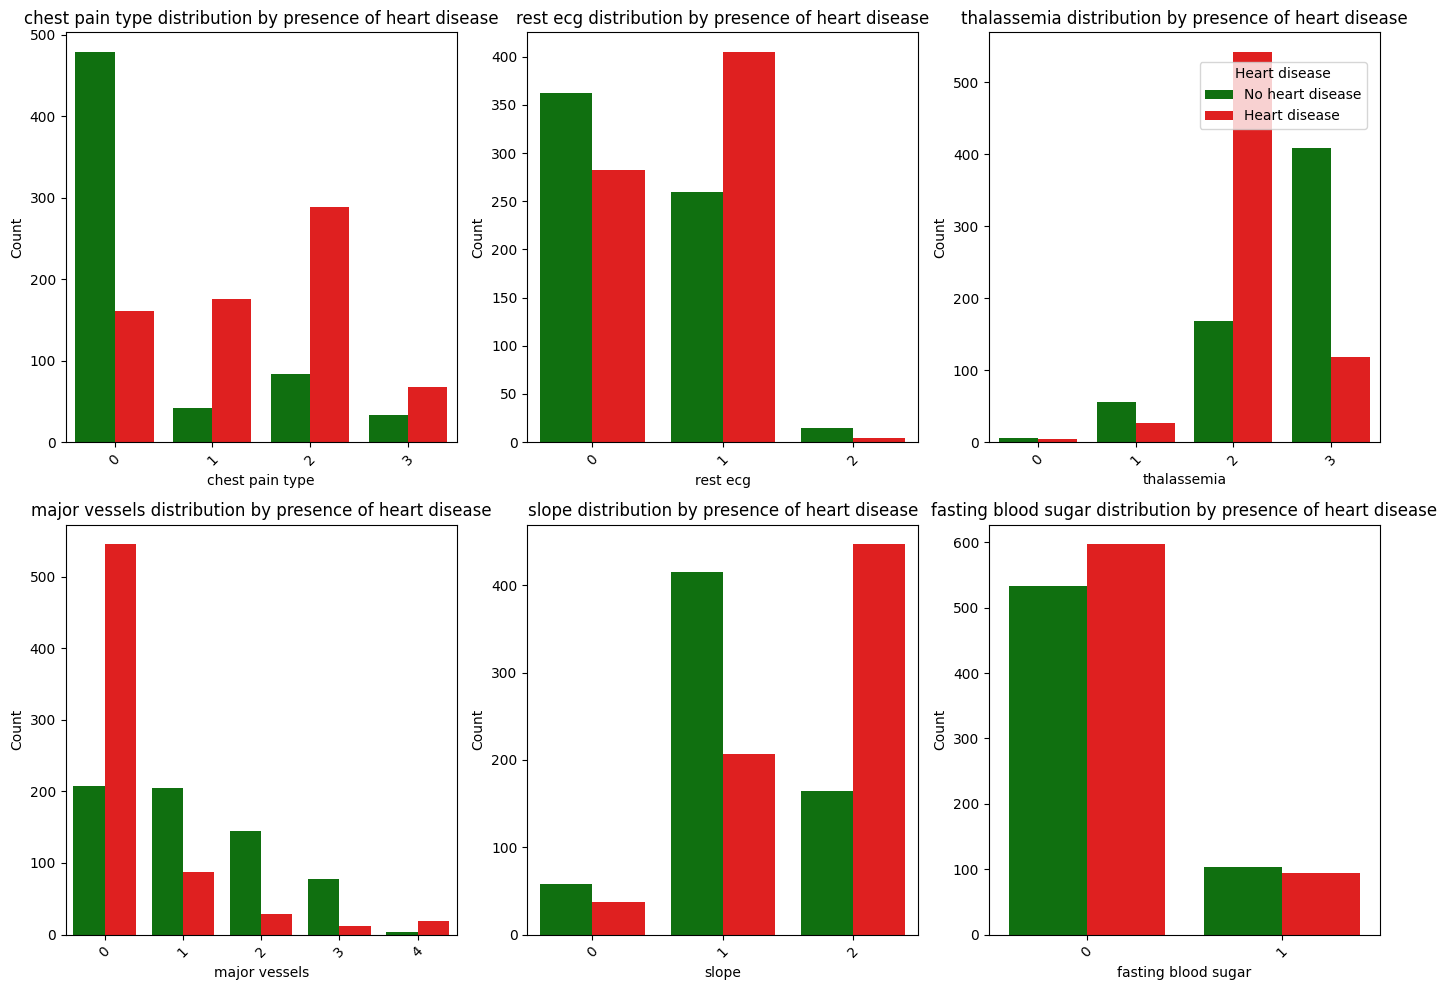

In [ ]:
cat_vars = ['chest pain type', 'rest ecg', 'thalassemia', 'major vessels', 'slope', 'fasting blood sugar']
palette_target = {1: 'red', 0: 'green'}

fig, axes = plt.subplots(2, 3, figsize=(14, 10))  
axes = axes.flatten() 

for ax, col in zip(axes, cat_vars):
    sns.countplot(
        data=combined, 
        x=col, 
        hue='target', 
        palette=palette_target, 
        ax=ax
    )
    ax.set_title(f"{col} distribution by presence of heart disease")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.legend_.remove()
    ax.tick_params(axis='x', rotation=45)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['No heart disease', 'Heart disease'], title='Heart disease', bbox_to_anchor=(0.985, 0.94))

plt.tight_layout()
plt.show()

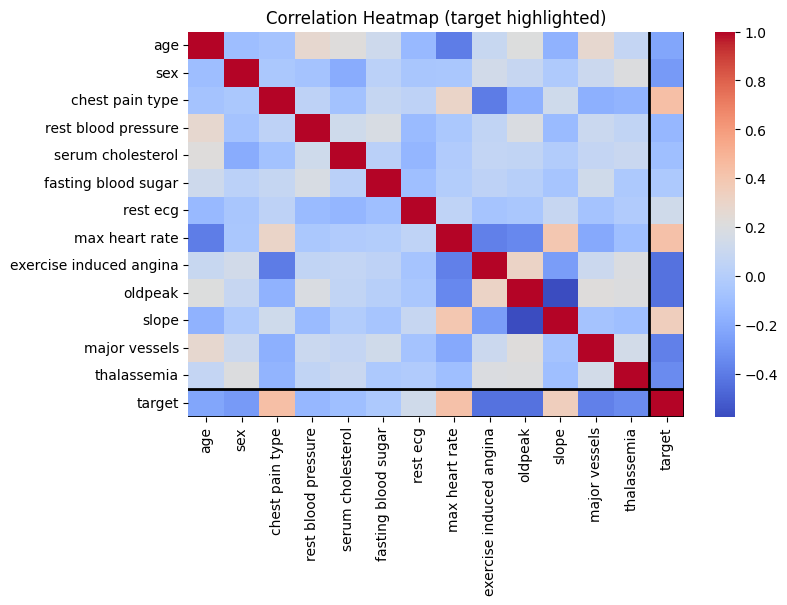

In [ ]:
import numpy as np

corr = combined.corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr, cmap='coolwarm', annot=False)

# find index of 'target' in the correlation matrix
cols = list(corr.columns)
t_idx = cols.index('target')

# draw box lines around that row & column
plt.axhline(t_idx,     color='black', linewidth=2)
plt.axhline(t_idx + 1, color='black', linewidth=2)
plt.axvline(t_idx,     color='black', linewidth=2)
plt.axvline(t_idx + 1, color='black', linewidth=2)

plt.title("Correlation Heatmap (target highlighted)")
plt.show()

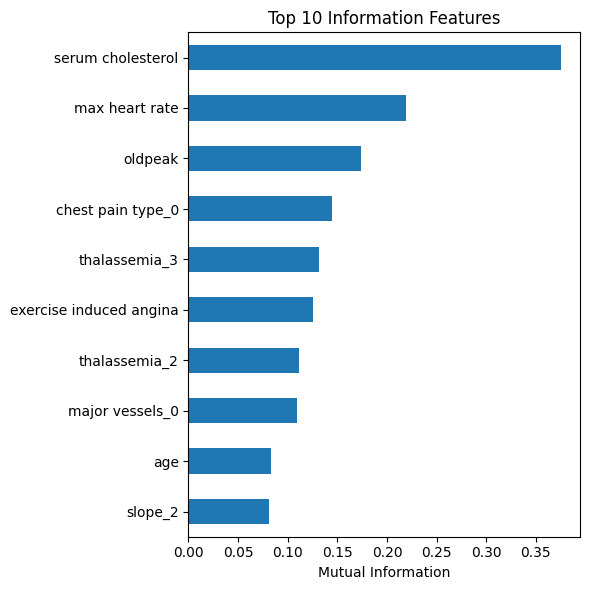

In [ ]:
X = df.drop(columns=['target'])
mi = mutual_info_classif(X, df['target'], discrete_features='auto')

mi_series = pd.Series(mi, index=X.columns).sort_values()

mi_top = mi_series.tail(10)

# Plot
plt.figure(figsize=(6,6))
mi_top.plot(kind='barh')
plt.title("Top 10 Information Features")
plt.xlabel("Mutual Information")
plt.tight_layout()
plt.show()

## <a id='toc1_4_'></a>[3. Basic Model: Logistic Regression](#toc0_)


### <a id='toc1_4_1_'></a>[3.1 Model Architecture](#toc0_)

**Logistic Regression** is the appropriate choice for this binary classification problem (predicting presence/absence of heart disease). 

**Model Formula:**
- The logistic regression model uses the logistic (sigmoid) function to map linear combinations of features to probabilities:
  
  $$P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n)}}$$
  
  where:
  - $P(Y=1|X)$ is the probability of heart disease given features $X$
  - $\beta_0$ is the intercept (bias term)
  - $\beta_1, \beta_2, ..., \beta_n$ are the coefficients for features $X_1, X_2, ..., X_n$
  - The sigmoid function ensures probabilities are between 0 and 1

- Predictions are made by thresholding the probability (typically at 0.5):
  - If $P(Y=1|X) \geq 0.5$ → predict heart disease (1)
  - If $P(Y=1|X) < 0.5$ → predict no heart disease (0)

**Why Logistic Regression?**
- We’re dealing with a yes/no problem (0 = no heart disease, 1 = heart disease)

- It gives clear coefficients so we can see which features matter most

- It’s fast to run and works great as a starting point

- Regular linear regression doesn’t fit here because it predicts continuous numbers, not probabilities


### <a id='toc1_4_2_'></a>[3.2 Data Preparation for Training](#toc0_)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

X = df.drop(columns=['target'])
y = df['target']


X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in validation set:")
print(y_val.value_counts())


Training set size: 1062 samples
Validation set size: 266 samples
Number of features: 27

Class distribution in training set:
target
1    553
0    509
Name: count, dtype: int64

Class distribution in validation set:
target
1    138
0    128
Name: count, dtype: int64


### <a id='toc1_4_3_'></a>[3.3 Model Training](#toc0_)


In [ ]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# train the model
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)

# get predicted probabilities (this is for ROC curve)
y_train_proba = log_reg.predict_proba(X_train)[:, 1]
y_val_proba = log_reg.predict_proba(X_val)[:, 1]

print("Model trained successfully!")
print(f"\nModel coefficients (first 10):")
coef_df = pd.DataFrame({
    'Feature': X_train.columns[:10],
    'Coefficient': log_reg.coef_[0][:10]
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df.to_string(index=False))
print(f"\nIntercept (bias term): {log_reg.intercept_[0]:.4f}")


Model trained successfully!

Model coefficients (first 10):
                Feature  Coefficient
                    sex    -1.501736
      chest pain type_0    -1.215734
exercise induced angina    -0.688287
                oldpeak    -0.445560
      chest pain type_1    -0.321654
    fasting blood sugar     0.149523
                    age     0.021438
    rest blood pressure    -0.020044
         max heart rate     0.019154
      serum cholesterol    -0.003931

Intercept (bias term): 0.6967


### <a id='toc1_4_4_'></a>[3.4 Model Evaluation](#toc0_)

**Evaluation Metrics:**
- **Accuracy**: Overall proportion of correct predictions
- **Precision**: Of predicted positives, how many are actually positive (reduces false positives)
- **Recall**: Of actual positives, how many are correctly identified (reduces false negatives)
- **F1 Score**: Harmonic mean of precision and recall (balanced metric)
- **ROC-AUC**: Area under the ROC curve (measures model's ability to distinguish between classes)
- **Confusion Matrix**: Shows true positives, false positives, true negatives, false negatives


In [16]:
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

train_precision = precision_score(y_train, y_train_pred)
val_precision = precision_score(y_val, y_val_pred)

train_recall = recall_score(y_train, y_train_pred)
val_recall = recall_score(y_val, y_val_pred)

train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)

train_roc_auc = roc_auc_score(y_train, y_train_proba)
val_roc_auc = roc_auc_score(y_val, y_val_proba)

results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'Training': [train_accuracy, train_precision, train_recall, train_f1, train_roc_auc],
    'Validation': [val_accuracy, val_precision, val_recall, val_f1, val_roc_auc]
})

results['Training'] = results['Training'].apply(lambda x: f"{x:.4f}")
results['Validation'] = results['Validation'].apply(lambda x: f"{x:.4f}")


print("LOGISTIC REGRESSION MODEL PERFORMANCE")

print(results.to_string(index=False))



LOGISTIC REGRESSION MODEL PERFORMANCE
   Metric Training Validation
 Accuracy   0.8936     0.8647
Precision   0.8754     0.8269
   Recall   0.9277     0.9348
 F1 Score   0.9008     0.8776
  ROC-AUC   0.9501     0.9184


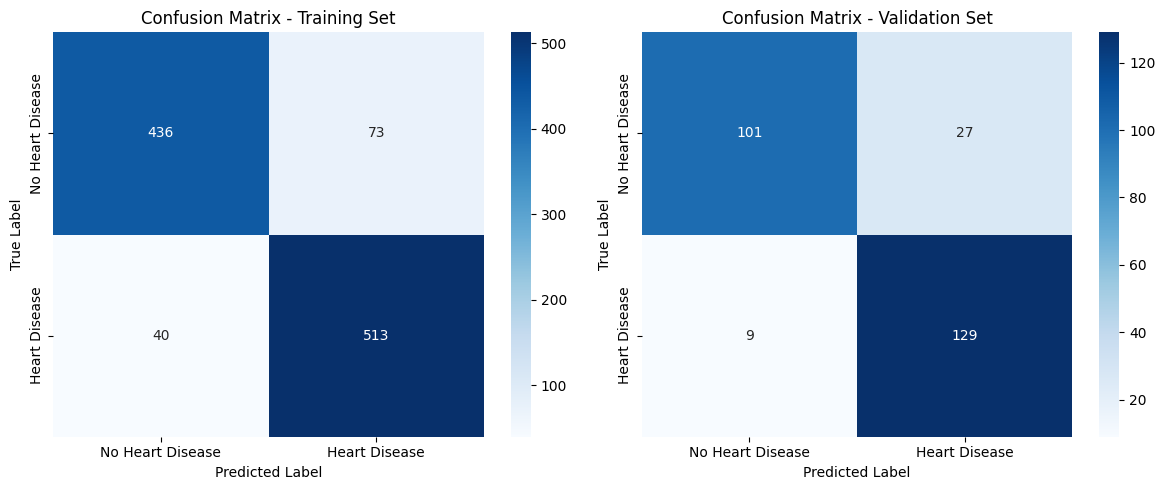


Training Set Confusion Matrix:
True Negatives: 436, False Positives: 73
False Negatives: 40, True Positives: 513

Validation Set Confusion Matrix:
True Negatives: 101, False Positives: 27
False Negatives: 9, True Positives: 129


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# and here is the confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
axes[0].set_title('Confusion Matrix - Training Set')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')


cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
axes[1].set_title('Confusion Matrix - Validation Set')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\nTraining Set Confusion Matrix:")
print(f"True Negatives: {cm_train[0,0]}, False Positives: {cm_train[0,1]}")
print(f"False Negatives: {cm_train[1,0]}, True Positives: {cm_train[1,1]}")

print("\nValidation Set Confusion Matrix:")
print(f"True Negatives: {cm_val[0,0]}, False Positives: {cm_val[0,1]}")
print(f"False Negatives: {cm_val[1,0]}, True Positives: {cm_val[1,1]}")


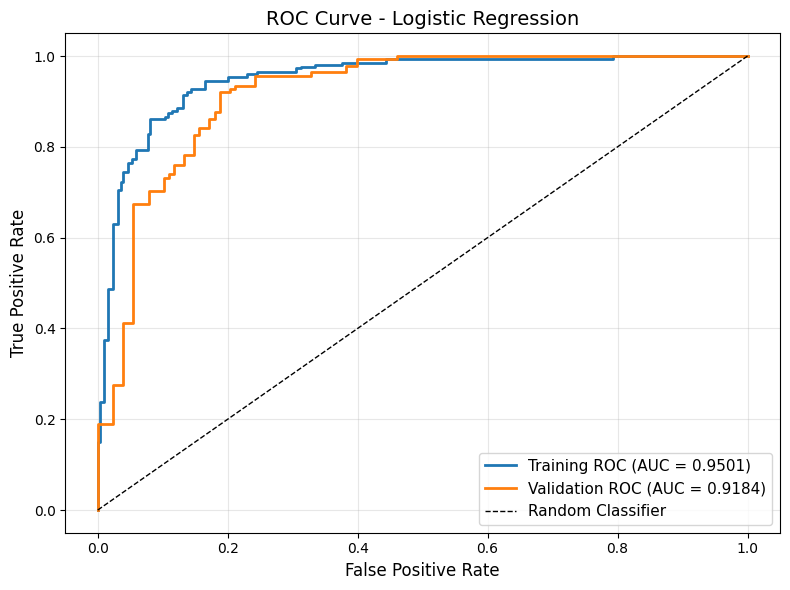

In [15]:
# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {train_roc_auc:.4f})', linewidth=2)
plt.plot(fpr_val, tpr_val, label=f'Validation ROC (AUC = {val_roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
